## Hybrid Sim V6

In [55]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import random
import ternary

In [56]:
# Set a random seed for reproducibility (if not required comment out line)

np.random.seed(38)
random.seed(38)

In [57]:
# Define constants
chromosome_length = 15 # Total number of positions (loci) on the chromosome 
MAGENTA = 'M'
YELLOW = 'Y'

In [58]:
#Option to change recombination probability. 

use_uniform_recomb = True  # Change to False to use custom recombination prob.

if use_uniform_recomb:
    recomb_probs = [0.1] * chromosome_length  # Same recombination probability across all positions
    # 10% chance
else:
    recomb_probs = [0.01, 0.05, 0.2, 0.2, 0.05, 0.01, 0.01, 0.05, 0.2, 0.2, 0.05, 0.01, 0.01, 0.05, 0.01]


### Parent generation

In [59]:
# Create MM and YY parent populations 
num_magenta = 10
num_yellow = 10

magenta_parents = [
    [[MAGENTA] * chromosome_length, [MAGENTA] * chromosome_length]
    for _ in range(num_magenta)
]

yellow_parents = [
    [[YELLOW] * chromosome_length, [YELLOW] * chromosome_length]
    for _ in range(num_yellow)
]

### F1 generation

In [60]:
# Function to generate F1 individual pop from MM x YY
def generate_f1_population_from_parents(n, magenta_pool, yellow_pool):
    f1_population = []
    f1_parent_indices = []  # Store the (MM, YY) parent indices for each F1 individual

    for _ in range(n):
        mm_index = random.randint(0, len(magenta_pool) - 1)
        yy_index = random.randint(0, len(yellow_pool) - 1)

        mm_parent = magenta_pool[mm_index]
        yy_parent = yellow_pool[yy_index]

        chr1 = mm_parent[0]  # Take one chr from MM
        chr2 = yy_parent[1]  # Take one chr from YY

        f1_population.append([chr1.copy(), chr2.copy()])
        f1_parent_indices.append((mm_index, yy_index))  # Save parent indices

    return f1_population, f1_parent_indices

In [61]:
# Generate F1 offspring
# This function selects one random MM parent and one random YY parent for each F1 individual to simulate a cross between them.
# Each resulting offspring has one chr from MM and one from YY.
f1_offspring, f1_parent_indices = generate_f1_population_from_parents(
    n=10, magenta_pool=magenta_parents, yellow_pool=yellow_parents
)

In [62]:
# Checkpoint 

print(f1_offspring)

[[['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'], ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']], [['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'], ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']], [['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'], ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']], [['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'], ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']], [['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'], ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']], [['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'], ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']], [['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', '

In [63]:
# Pick two distinct F1 parents at random from F1 population
parent_indices = np.random.choice(len(f1_offspring), 2, replace=False) # The same individual can not be picked twice.

# Get the F1 individual corresponding to the first selected index 
parent_a = f1_offspring[parent_indices[0]]
# Get the F1 individual corresponding to the second selected index
parent_b = f1_offspring[parent_indices[1]]

In [64]:
# Checkpoint

print(parent_a)
print(parent_b)

[['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'], ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']]
[['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'], ['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']]


In [65]:
# Checkpoint

print(parent_indices)

[8 0]


In [66]:
# Get which MM and YY parents made each selected F1 parent
f1a_mm_index, f1a_yy_index = f1_parent_indices[parent_indices[0]]
f1b_mm_index, f1b_yy_index = f1_parent_indices[parent_indices[1]]

# Fetch the actual individuals
mm_parent_a = magenta_parents[f1a_mm_index]
yy_parent_a = yellow_parents[f1a_yy_index]

mm_parent_b = magenta_parents[f1b_mm_index]
yy_parent_b = yellow_parents[f1b_yy_index]

# F1 individuals already known:
f1_a = parent_a
f1_b = parent_b

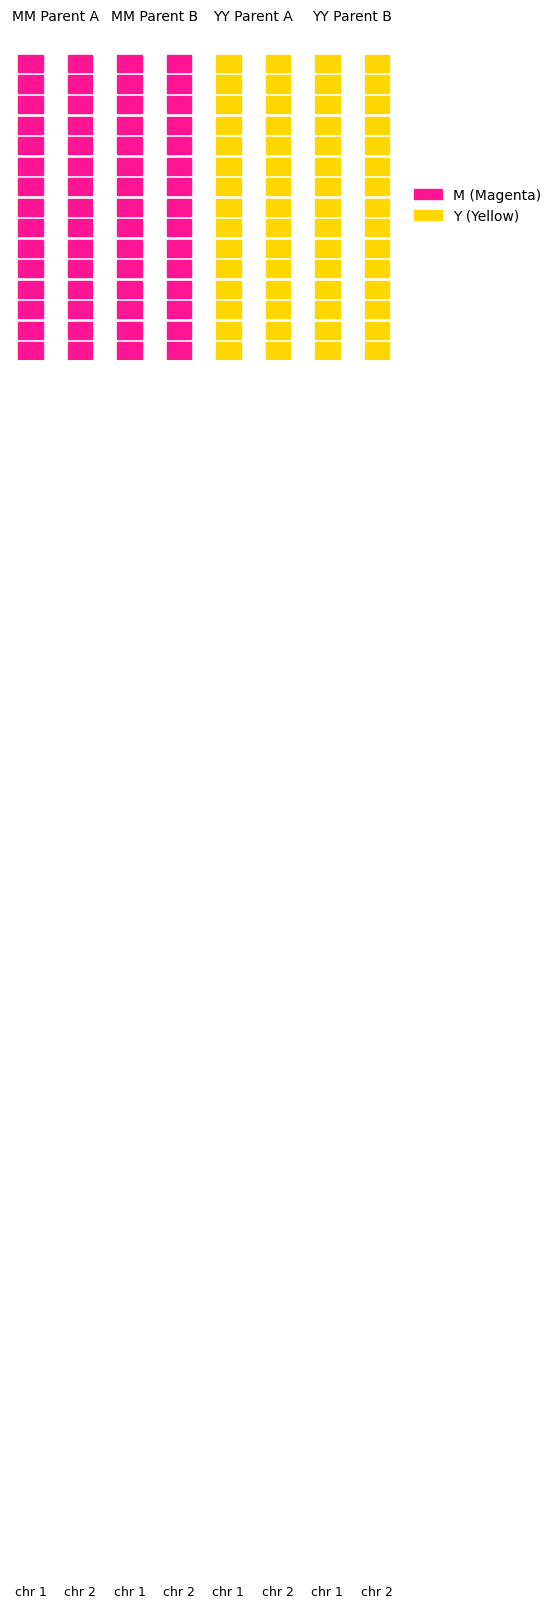

In [90]:
# Visualise parents
# Colour map for alleles
color_map = {'M': 'deeppink', 'Y': 'gold'}

# Updated order: MM A, MM B, YY A, YY B
titles = ["MM Parent A", "MM Parent B", "YY Parent A", "YY Parent B"]

# Chromosome pairs per individual (same order as titles)
parent_chr_pairs = [
    (mm_parent_a[0], mm_parent_a[1]),
    (mm_parent_b[0], mm_parent_b[1]),
    (yy_parent_a[0], yy_parent_a[1]),
    (yy_parent_b[0], yy_parent_b[1])
]

# 1 row, 2 chromosomes per individual = 8 total
fig, axs = plt.subplots(1, 8, figsize=(5, 4), sharey=True)

# Drawing settings
block_width = 0.6
block_height = 1
block_spacing = 1.2

# Loop through each individual and each chromosome
for i, (chr1, chr2) in enumerate(parent_chr_pairs):
    for j, chr in enumerate([chr1, chr2]):  # chr1 (0), chr2 (1)
        ax_index = i * 2 + j  # Convert to flat index (0 to 7)
        ax = axs[ax_index]
        for k, allele in enumerate(chr):
            y_pos = k * block_spacing
            ax.add_patch(
                mpatches.Rectangle((0.2, y_pos), block_width, block_height, color=color_map[allele])
            )
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(chr) * block_spacing)
        ax.axis('off')

# Add individual titles centered above each pair of chromosomes
for i, title in enumerate(titles):
    mid_ax = axs[i * 2 + 0]
    mid_x = mid_ax.get_position().x0 + (axs[i * 2 + 1].get_position().x1 - mid_ax.get_position().x0) / 2
    fig.text(mid_x, 0.95, title, ha='center', va='bottom', fontsize=10)

# Add chromosome labels below each block
for i in range(4):  # For each parent
    axs[i * 2 + 0].text(0.5, -4, "chr 1", ha='center', va='center', fontsize=9, transform=axs[i * 2 + 0].transAxes)
    axs[i * 2 + 1].text(0.5, -4, "chr 2", ha='center', va='center', fontsize=9, transform=axs[i * 2 + 1].transAxes)

# Add legend
legend_patches = [
    mpatches.Patch(color='deeppink', label='M (Magenta)'),
    mpatches.Patch(color='gold', label='Y (Yellow)')
]
axs[-1].legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.1, 0.5), frameon=False)

plt.show()

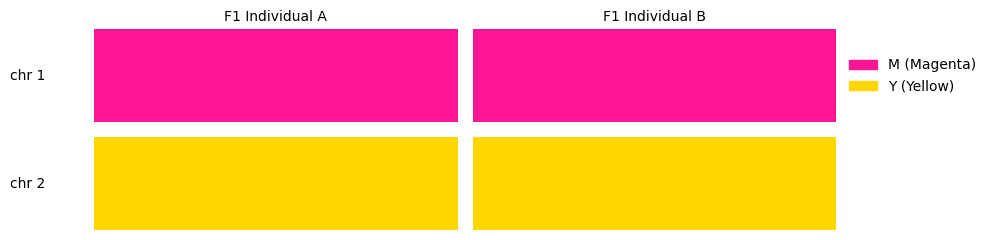

In [68]:
# Visualise F1 individuals 
fig, axs = plt.subplots(2, 2, figsize=(10, 2.5), sharex=True)

# Titles for each F1 individual
titles = ["F1 Individual A", "F1 Individual B"]

# F1 chr data grouped
f1_chr_pairs = [
    (f1_a[0], f1_a[1]),
    (f1_b[0], f1_b[1])
]

# Plot each F1 individual
for col, (chr1, chr2) in enumerate(f1_chr_pairs):
    for row, chr in enumerate([chr1, chr2]):
        for i, allele in enumerate(chr):
            axs[row][col].add_patch(mpatches.Rectangle((i, 0), 1, 1, color=color_map[allele]))
        axs[row][col].set_xlim(0, chromosome_length)
        axs[row][col].set_ylim(0, 1)
        axs[row][col].axis('off')
    axs[0][col].set_title(titles[col], fontsize=10)

# Add chr labels to left side
axs[0][0].text(-2, 0.5, "chr 1", va='center', ha='right', fontsize=10)
axs[1][0].text(-2, 0.5, "chr 2", va='center', ha='right', fontsize=10)

# Add legend
axs[0][1].legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.tight_layout()
plt.show()

### Hybrid Index Calculation Parents and F1

In [69]:
# 'M' = magenta, 'Y' = yellow
# MM = 2, MY/YM = 1, YY = 0

# Function to convert two chrs into numeric genotypes
def get_numeric_genotype(chr1, chr2):
    numeric = []
    for a, b in zip(chr1, chr2):
        pair = sorted([a, b])  # account for 'MY' and 'YM' 
        if pair == ['M', 'M']:
            numeric.append(2)
        elif pair == ['Y', 'Y']:
            numeric.append(0)
        else:
            numeric.append(1)
    return numeric

# Function to calculate HI and HET from numeric genotype
def calculate_hi_het(genotype_numeric):
    num_loci = len(genotype_numeric)
    total_alleles = 2 * num_loci
    num_mm = genotype_numeric.count(2)
    num_yy = genotype_numeric.count(0)
    num_het = genotype_numeric.count(1)
    num_m_alleles = (2 * num_mm) + (1 * num_het)
    hi = num_m_alleles / total_alleles
    het = num_het / num_loci
    return hi, het

# Get numerci genotype for each individual 

# MM and YY parents of F1_A
genotype_mm_a = get_numeric_genotype(mm_parent_a[0], mm_parent_a[1])
genotype_yy_a = get_numeric_genotype(yy_parent_a[0], yy_parent_a[1])

# MM and YY parents of F1_B
genotype_mm_b = get_numeric_genotype(mm_parent_b[0], mm_parent_b[1])
genotype_yy_b = get_numeric_genotype(yy_parent_b[0], yy_parent_b[1])

# F1 Individuals
genotype_f1_a = get_numeric_genotype(f1_a[0], f1_a[1])
genotype_f1_b = get_numeric_genotype(f1_b[0], f1_b[1])

# Calculate HI and HET (Hybrid Index and Heterozygosity)

hi_mm_a, het_mm_a = calculate_hi_het(genotype_mm_a)
hi_yy_a, het_yy_a = calculate_hi_het(genotype_yy_a)

hi_mm_b, het_mm_b = calculate_hi_het(genotype_mm_b)
hi_yy_b, het_yy_b = calculate_hi_het(genotype_yy_b)

hi_f1_a, het_f1_a = calculate_hi_het(genotype_f1_a)
hi_f1_b, het_f1_b = calculate_hi_het(genotype_f1_b)

In [70]:
# Output results 

print(f"F1_A's MM Parent -> HI: {hi_mm_a:.2f}, HET: {het_mm_a:.2f}")
print(f"F1_A's YY Parent -> HI: {hi_yy_a:.2f}, HET: {het_yy_a:.2f}")
print(f"F1_A Individual  -> HI: {hi_f1_a:.2f}, HET: {het_f1_a:.2f}")
print()
print(f"F1_B's MM Parent -> HI: {hi_mm_b:.2f}, HET: {het_mm_b:.2f}")
print(f"F1_B's YY Parent -> HI: {hi_yy_b:.2f}, HET: {het_yy_b:.2f}")
print(f"F1_B Individual  -> HI: {hi_f1_b:.2f}, HET: {het_f1_b:.2f}")


F1_A's MM Parent -> HI: 1.00, HET: 0.00
F1_A's YY Parent -> HI: 0.00, HET: 0.00
F1_A Individual  -> HI: 0.50, HET: 1.00

F1_B's MM Parent -> HI: 1.00, HET: 0.00
F1_B's YY Parent -> HI: 0.00, HET: 0.00
F1_B Individual  -> HI: 0.50, HET: 1.00


### F2 generation

In [71]:
# Simulate F2 offspring
# Create an empty list for new F2 chrs
chr_1 = []
chr_2 = []

# Randomly choose which F1 parent to start with for creating the F2
chr_1_source = np.random.choice([0, 1])  # 0 = parent A, 1 = parent B
chr_2_source = np.random.choice([0, 1])

# Loop through each position (locus) in the chromosome 
for i in range(chromosome_length):

    #For chr 1, randomly select if recombination happens at this position based on the recomb_prob.
    #If yes, switch the source parent for this chr. 
    if i > 0 and np.random.rand() < recomb_probs[i]:
        chr_1_source = 1 - chr_1_source # Work between parent 0 and 1 

    # For chr 2, do the same as above and change where required. 
    if i > 0 and np.random.rand() < recomb_probs[i]:
        chr_2_source = 1 - chr_2_source

    # Append allele from designated parent and position. 
    # Dependent on the source parent. 
    chr_1.append(parent_a[chr_1_source][i] if chr_1_source == 0 else parent_b[chr_1_source][i])
    chr_2.append(parent_a[chr_2_source][i] if chr_2_source == 0 else parent_b[chr_2_source][i])

In [72]:
# Checkpoint: print chr data

print("F2 offspring chrs generated:")
print("chr 1:", chr_1)
print("chr 2:", chr_2)

F2 offspring chrs generated:
chr 1: ['M', 'M', 'M', 'M', 'M', 'M', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']
chr 2: ['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'Y', 'M', 'Y', 'Y', 'Y', 'Y', 'Y']


In [73]:
# Compute genotype numeric representation
# Create lists to store numeric and label data
f2_chromosome = []          # Numerical representation (2, 1, 0)
f2_genotype_labels = []     # Actual chr combinations ('MM', 'MY', 'YM', 'YY')

# Loop through alleles at each position from both chrs at the same time.
for a, b in zip(chr_1, chr_2):

    # Combine into pairs and assign numeric genotype
    pair = sorted([a, b])
    
    if pair == ['M', 'M']:
        f2_chromosome.append(2)
        f2_genotype_labels.append('MM')
    elif pair == ['Y', 'Y']:
        f2_chromosome.append(0)
        f2_genotype_labels.append('YY')
    else:
        f2_chromosome.append(1)
        f2_genotype_labels.append(a + b)  #Actual orientation: 'MY' or 'YM'

In [74]:
# Checkpoint: print genotype array

print("F2 genotype numeric values:", f2_chromosome)
print("F2 genotype chr labels :", f2_genotype_labels)

F2 genotype numeric values: [2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0]
F2 genotype chr labels : ['MM', 'MM', 'MM', 'MM', 'MM', 'MM', 'YM', 'YM', 'YY', 'YM', 'YY', 'YY', 'YY', 'YY', 'YY']


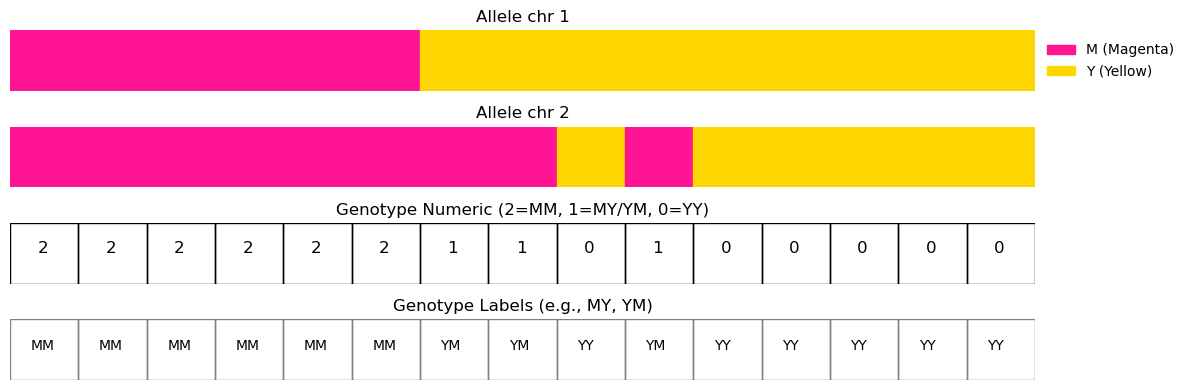

In [75]:
# Visualise F2 chromosome
# Define colour for M and Y
color_map = {'M': 'deeppink', 'Y': 'gold'}
# Create a figure with 4 vertically stacked subplots 
fig, axs = plt.subplots(4, 1, figsize=(12, 4), sharex=True)

# Set titles for each subplot row
axs[0].set_title("Allele chr 1")
axs[1].set_title("Allele chr 2")
axs[2].set_title("Genotype Numeric (2=MM, 1=MY/YM, 0=YY)")
axs[3].set_title("Genotype Labels (e.g., MY, YM)")

# Plot all allele colours, geotype values  and labels 
for i, allele in enumerate(chr_1):
    axs[0].add_patch(mpatches.Rectangle((i, 0), 1, 1, color=color_map[allele]))
for i, allele in enumerate(chr_2):
    axs[1].add_patch(mpatches.Rectangle((i, 0), 1, 1, color=color_map[allele]))
for i, val in enumerate(f2_chromosome):
    axs[2].text(i + 0.4, 0.5, str(val), fontsize=12)
    axs[2].add_patch(mpatches.Rectangle((i, 0), 1, 1, edgecolor='black', facecolor='white', fill=False))
for i, label in enumerate(f2_genotype_labels):
    axs[3].text(i + 0.3, 0.5, label, fontsize=10)
    axs[3].add_patch(mpatches.Rectangle((i, 0), 1, 1, edgecolor='grey', facecolor='white', fill=False))

# Format each subplot
for ax in axs:
    ax.set_xlim(0, chromosome_length)
    ax.set_ylim(0, 1)
    ax.axis('off')

# Add legend
legend_patches = [
    mpatches.Patch(color='deeppink', label='M (Magenta)'),
    mpatches.Patch(color='gold', label='Y (Yellow)')
]
axs[0].legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust spacing and display 
plt.tight_layout()
plt.show()

In [76]:
# Checkpoint - for verification purposes 

print("chr 1:", chr_1)
print("chr 2:", chr_2)
print("F2 Chromosome Genotype:", f2_chromosome)

chr 1: ['M', 'M', 'M', 'M', 'M', 'M', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']
chr 2: ['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'Y', 'M', 'Y', 'Y', 'Y', 'Y', 'Y']
F2 Chromosome Genotype: [2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 0, 0, 0, 0, 0]


### Hybrid Index Calculation F2

In [77]:
# Genotype representatives 
# 2 = MM
# 1 = MY or YM
# 0 = YY

# F2 individual’s genotype
genotype_numeric = f2_chromosome  

# Count the total number of loci (positions along the chromosome)
num_loci = len(genotype_numeric)

# Each locus has 2 alleles, so total alleles = 2 * number of loci
total_alleles = 2 * num_loci

# Count MM loci (value = 2)
num_mm = genotype_numeric.count(2)

# Count heterzygous loci (MY or YM) (value = 1)
num_het = genotype_numeric.count(1)

# Count YY loci (value = 0)
num_yy = genotype_numeric.count(0)

# Calculate the total number of M alleles for hybrid index claculation 
# Each MM contributes 2 M alleles
# Each MY/YM contributes 1 M allele
# YY contributes 0 M alleles
num_m_alleles = (2 * num_mm) + (1 * num_het)

# Hybrid Index Calculation 
# Proportion of M alleles out of all alleles
hybrid_index = num_m_alleles / total_alleles

# Calculate heterozygosity:
# This is the proportion of heterozygous loci
heterozygosity = num_het / num_loci

hi_f2 = hybrid_index
het_f2 = heterozygosity


In [78]:
# Print results
print(hi_f2) # Value from 0 (YY) to 1 (MM)
print(het_f2) # Value from 0 (none heterozygous) to 1 (all heterozygous) along loci

0.5
0.2


In [79]:
# Example output: 

#Hybrid Index: 0.50
#Heterozygosity: 0.20

#Hybrid index is not skewed to either M or Y here. 

### Triangle Plot

In [80]:
# Lists for plotting to contain HI, Het for each specific individual plotting points. 
points = [
    (hi_mm_a, het_mm_a), # F1_A MM parent
    (hi_yy_a, het_yy_a), # F1_A YY parent
    (hi_f1_a, het_f1_a), # F1_A individual 
    
    (hi_mm_b, het_mm_b), # F1_B MM parent 
    (hi_yy_b, het_yy_b), # F1_B YY parent 
    (hi_f1_b, het_f1_b), # F1_B individual 
    
    (hi_f2, het_f2), # F2 individual 
]

# Create a list for each point above to be labelled 
# Labels for annotation on graph 

labels = [
    "MM_A", "YY_A", "F1_A",
    "MM_B", "YY_B", "F1_B",
    "F2"  
]

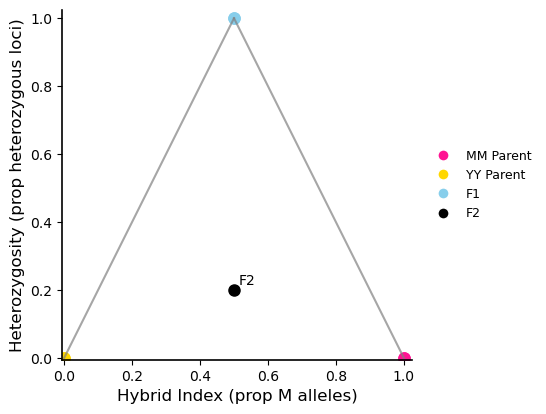

In [81]:
# Indicate plotting scale
# Hybrid index (HI) goes from 0 to 1 on the x-axis (from YY to MM)
# Heterozygosity (HET) goes from 0 to 1 on the y-axis (max at 50:50 inheritance)

# Define colours for each label
label_colors = {
    "YY_A": "gold",      # Yellow parent
    "MM_A": "deeppink",  # Magenta parent
    "YY_B": "gold",
    "MM_B": "deeppink",
    "F1_A": "skyblue",
    "F1_B": "skyblue",
    "F2": "black"
}

# Create the plot
fig, ax = plt.subplots(figsize=(5, 5))

# Remove only top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Label axes
ax.set_xlabel("Hybrid Index (prop M alleles)", fontsize=12)
ax.set_ylabel("Heterozygosity (prop heterozygous loci)", fontsize=12)

# Track legend handles
legend_handles = []

# Plot points
for (x, y), label in zip(points, labels):
    color = label_colors.get(label, "blue")  # Default color
    ax.plot(x, y, 'o', markersize=8, color=color, label=label)

    # Only label F2 directly on the plot
    if label == "F2":
        ax.text(x + 0.015, y + 0.015, label, fontsize=10)

# Set axis limits and grid
ax.set_xlim(-0.005, 1.025)
ax.set_ylim(-0.005, 1.025)
ax.grid(False)
#ax.set_title("Hybrid Index vs. Heterozygosity", fontsize=14)
ax.set_aspect('equal', adjustable='box')

# Add triangle boundary
# Triangle edges — omit the bottom line (YY to MM)
triangle_edges = [
    [(0.0, 0.0), (0.5, 1.0)],  # YY to F1
    [(0.5, 1.0), (1.0, 0.0)]   # F1 to MM
]

# Plot only the two side edges
for (x0, y0), (x1, y1) in triangle_edges:
    ax.plot([x0, x1], [y0, y1], linestyle='-', color='gray', linewidth=1.5, alpha=0.7)

# Manually define custom legend entries
custom_legend = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='deeppink', markersize=8, label='MM Parent'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', markersize=8, label='YY Parent'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=8, label='F1'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='F2')
]

# Add legend on the right side
ax.legend(
    handles=custom_legend,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=9
)


plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.2)
plt.show()
